In [ ]:
#!pip uninstall -y qiskit qiskit-terra qiskit-aer qiskit-ibmq-provider qiskit-machine-learning qiskit-nature qiskit-finance qiskit-optimization


In [ ]:
!pip install --upgrade pip
!pip install "qiskit>=1.1.0" "qiskit-aer>=0.14.2" torch numpy matplotlib scipy


In [3]:
import qiskit
print("Qiskit version:", qiskit.__version__)


Qiskit version: 2.2.3


In [ ]:
!pip install mitiq

In [14]:
!pip install numpy==1.26.4

In [ ]:
!pip install 'qiskit-addon-utils'

In [1]:
# Cell 0: Imports & dependency check
import sys, os, math, time, copy, random
from dataclasses import dataclass
from typing import List, Tuple, Optional

import numpy as np
import matplotlib.pyplot as plt

# Import Qiskit + Aer;
HAS_QISKIT = False
HAS_AER = False
try:
    import qiskit
    from qiskit import QuantumCircuit, transpile
    from qiskit.providers.aer import AerSimulator
    from qiskit.providers.aer.noise import NoiseModel
    from qiskit.quantum_info import Statevector, Operator
    HAS_QISKIT = True
    try:
        # Attempt to instantiate AerSimulator to ensure qiskit-aer available
        _ = AerSimulator()
        HAS_AER = True
    except Exception:
        HAS_AER = False
except Exception:
    HAS_QISKIT = False
    HAS_AER = False

# PyTorch for PPO
try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.distributions import Categorical
    HAS_TORCH = True
except Exception:
    HAS_TORCH = False

print("HAS_QISKIT:", HAS_QISKIT, "HAS_AER:", HAS_AER, "HAS_TORCH:", HAS_TORCH)
if not (HAS_QISKIT and HAS_AER):
    print("\nNOTE: Qiskit/Aer not fully available. Cells that need realistic noise models will fall back to toy simulator.")
if not HAS_TORCH:
    raise RuntimeError("PyTorch (torch) is required for the PPO implementation. Install with `pip install torch`.")


HAS_QISKIT: False HAS_AER: False HAS_TORCH: True

NOTE: Qiskit/Aer not fully available. Cells that need realistic noise models will fall back to toy simulator.


Utility Functions — Extrapolators

This cell defines **mathematical extrapolation models** used by ZNE to predict the "zero-noise" observable value based on noisy measurements at different noise levels.

Three common extrapolators are implemented:

1. **Linear extrapolation:** Fits a line `y = ax + b` to `(λ, value)` pairs and estimates the noise-free limit at `λ → 0`.

2. **Polynomial (quadratic) extrapolation:** Fits a second-order polynomial for more complex noise dependencies.

3. **Exponential extrapolation:** Fits an exponential decay model assuming error processes cause multiplicative damping.

A global dictionary `EXTRAPOLATORS` maps integer IDs (0,1,2) to these models, allowing the RL agent to treat the extrapolator selection as a discrete action during training.


In [2]:
# Cell 1: Utility functions - extrapolators (linear, poly2, exponential)
import warnings


def linear_extrapolate(lambdas: List[float], values: List[float]) -> float:
    if len(lambdas) < 2:
        return values[0]
    A = np.vstack([lambdas, np.ones_like(lambdas)]).T
    sol, *_ = np.linalg.lstsq(A, values, rcond=None)
    a, b = sol[0], sol[1]
    return float(b)

def poly2_extrapolate(lambdas: List[float], values: List[float]) -> float:
    if len(lambdas) < 2:
        return values[0]
    A = np.vstack([np.array(lambdas)**2, np.array(lambdas), np.ones_like(lambdas)]).T
    sol, *_ = np.linalg.lstsq(A, values, rcond=None)
    return float(sol[2])

def exponential_extrapolate(lambdas: List[float], values: List[float]) -> float:
    lambdas = np.array(lambdas)
    values = np.array(values)
    minv = values.min()
    shift = 0.0
    if minv <= 0:
        shift = 1e-8 - minv
        values = values + shift
    if len(lambdas) == 1:
        return float(values[0] - shift)
    try:
        coefs = np.polyfit(lambdas, np.log(values), 1)
        c = -coefs[0]
        ln_b = coefs[1]
        b = math.exp(ln_b)
        return float(b - shift)
    except Exception:
        return float(values[0] - shift)

EXTRAPOLATORS = {
    0: ("linear", linear_extrapolate),
    1: ("poly2", poly2_extrapolate),
    2: ("exponential", exponential_extrapolate)
}


###Cell 2: Circuit Generator — XYZ / TFIM Hamiltonian Simulation

This cell constructs **Hamiltonian simulation circuits** for the **XYZ spin model** or **Transverse Field Ising Model (TFIM)** using Qiskit’s `PauliEvolutionGate` and `SuzukiTrotter` decomposition.

The Hamiltonian implemented is:

$[
H = \sum_i \big( J_x X_i X_{i+1} + J_y Y_i Y_{i+1} + J_z Z_i Z_{i+1} \big)
  + \sum_i \big( h_x X_i + h_y Y_i + h_z Z_i \big)
]$

- Each pairwise Pauli term is added as a **SparsePauliOp**, enabling efficient construction and manipulation.
- The time-evolution operator \( e^{-iHΔt} \) is approximated using the **Suzuki–Trotter** method for a given number of Trotter steps.

This produces realistic test circuits for studying **error accumulation** under noisy conditions and for applying **Zero Noise Extrapolation** later in the notebook.


In [3]:
# Cell 2: Circuit generators - XYZ / TFIM Hamiltonian Trotterized circuits (Qiskit ≥1.0)
import numpy as np
from qiskit import QuantumCircuit
from qiskit.transpiler import CouplingMap
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import SuzukiTrotter

def generate_xyz_hamiltonian_sparse(
    n_qubits: int,
    Jx: float = 0.4,
    Jy: float = 0.4,
    Jz: float = 0.0,
    hx: float = 0.0,
    hy: float = 0.0,
    hz: float = 0.6
) -> SparsePauliOp:
    """
    Build an XYZ (or TFIM) Hamiltonian in SparsePauliOp form.

    H = Σ_i [ Jx*X_i X_{i+1} + Jy*Y_i Y_{i+1} + Jz*Z_i Z_{i+1} ]
        + Σ_i [ hx*X_i + hy*Y_i + hz*Z_i ]
    with open boundary conditions.
    """
    terms = []
    coeffs = []

    # two-qubit couplings
    for i in range(n_qubits - 1):
        if abs(Jx) > 1e-10:
            pauli = ["I"] * n_qubits
            pauli[i] = "X"
            pauli[i + 1] = "X"
            terms.append("".join(pauli))
            coeffs.append(Jx)
        if abs(Jy) > 1e-10:
            pauli = ["I"] * n_qubits
            pauli[i] = "Y"
            pauli[i + 1] = "Y"
            terms.append("".join(pauli))
            coeffs.append(Jy)
        if abs(Jz) > 1e-10:
            pauli = ["I"] * n_qubits
            pauli[i] = "Z"
            pauli[i + 1] = "Z"
            terms.append("".join(pauli))
            coeffs.append(Jz)

    # single-qubit fields
    for i in range(n_qubits):
        if abs(hx) > 1e-10:
            pauli = ["I"] * n_qubits
            pauli[i] = "X"
            terms.append("".join(pauli))
            coeffs.append(hx)
        if abs(hy) > 1e-10:
            pauli = ["I"] * n_qubits
            pauli[i] = "Y"
            terms.append("".join(pauli))
            coeffs.append(hy)
        if abs(hz) > 1e-10:
            pauli = ["I"] * n_qubits
            pauli[i] = "Z"
            terms.append("".join(pauli))
            coeffs.append(hz)

    return SparsePauliOp.from_list(list(zip(terms, coeffs)))


def xyz_trotter_circuit(
    n_qubits: int = 4,
    trotter_steps: int = 2,
    dt: float = 0.1,
    Jx: float = 0.4,
    Jy: float = 0.4,
    Jz: float = 0.0,
    hx: float = 0.0,
    hy: float = 0.0,
    hz: float = 0.6,
    with_measure: bool = False
) -> QuantumCircuit:
    """
    Build a Trotterized time-evolution circuit for the XYZ / TFIM Hamiltonian
    using Qiskit 1.x `PauliEvolutionGate` (no deprecated opflow).

    Args:
        n_qubits: number of qubits.
        trotter_steps: number of Trotter repetitions.
        dt: time-step size.
        Jx, Jy, Jz: coupling strengths.
        hx, hy, hz: external field strengths.
        with_measure: whether to append measurements.
    """
    # Hamiltonian as SparsePauliOp
    H = generate_xyz_hamiltonian_sparse(n_qubits, Jx, Jy, Jz, hx, hy, hz)

    # Create the Trotter evolution gate using new synthesis interface
    evo_gate = PauliEvolutionGate(
        H,
        time=dt,
        synthesis=SuzukiTrotter(reps=1)  # single step per Trotter iteration
    )

    # Compose the evolution multiple times
    qc = QuantumCircuit(n_qubits)
    for _ in range(trotter_steps):
        qc.append(evo_gate, range(n_qubits))

    if with_measure:
        qc.measure_all()

    return qc


# --- Example test: small TFIM circuit ---
qc_test = xyz_trotter_circuit(n_qubits=3, trotter_steps=2, dt=0.1, Jx=0.5, hz=0.7, with_measure=True)
print(qc_test)


        ┌──────────────────────────────────────────────────────────┐»
   q_0: ┤0                                                         ├»
        │                                                          │»
   q_1: ┤1 exp(-it (XXI + YYI + IXX + IYY + ZII + IZI + IIZ))(0.1) ├»
        │                                                          │»
   q_2: ┤2                                                         ├»
        └──────────────────────────────────────────────────────────┘»
meas: 3/════════════════════════════════════════════════════════════»
                                                                    »
«        ┌──────────────────────────────────────────────────────────┐ ░ ┌─┐   »
«   q_0: ┤0                                                         ├─░─┤M├───»
«        │                                                          │ ░ └╥┘┌─┐»
«   q_1: ┤1 exp(-it (XXI + YYI + IXX + IYY + ZII + IZI + IIZ))(0.1) ├─░──╫─┤M├»
«        │                                        

 Noise Amplification Utilities — Folding, Mirroring, and Cliffordization

To simulate and control noise scaling, this cell defines three quantum circuit transformation utilities:

1. **`fold_circuit(qc, λ)`**  
   Implements *gate folding*, a method used in ZNE to artificially amplify noise while preserving logical circuit functionality.  
   For example, $\( U \to U (U U^\dagger)^{k-1} \)$ increases circuit depth by a factor ≈ λ.

2. **`mirror_circuit(qc)`**  
   Creates a mirrored circuit $\( U U^\dagger \)$.  
   This type of circuit ideally returns to the ground state, providing a known baseline expectation (useful for calibration).

3. **`cliffordize_circuit(qc)`**  
   Approximates continuous rotations (RX/RY/RZ) by the nearest Clifford operations.  
   Cliffordized circuits can be simulated efficiently and are useful for debugging and benchmarking noise effects.


In [5]:
# Cell 3: Circuit folding, mirrored, and Cliffordized utilities (Qiskit ≥1.0)
import math
import numpy as np

try:
    from qiskit import QuantumCircuit
    from qiskit.converters import circuit_to_dag, dag_to_circuit
    from qiskit.quantum_info import Clifford, SparsePauliOp
    HAS_QISKIT = True
except Exception:
    HAS_QISKIT = False


def fold_circuit(qc: "QuantumCircuit", lam: float) -> "QuantumCircuit":
    r"""
    Fold circuit to amplify noise.

    For a digital fold factor λ (e.g., 2.0), we repeat the unitary and its inverse
    to increase the number of gates, while preserving the logical function.

    Implementation:
      folded = U + (U U†) * (k-1) + optionally partial folding for fractional λ.

    Args:
        qc: Base QuantumCircuit.
        lam: Folding factor λ ≥ 1.
    """
    if not HAS_QISKIT:
        return {"folded_from": qc, "lam": lam}

    lam = float(lam)
    if lam <= 1.0:
        return qc.copy()

    k = int(math.floor(lam))
    frac = lam - k

    folded = qc.copy()
    # Integer folds: repeat U U† pairs
    for _ in range(max(0, k - 1)):
        folded = folded.compose(qc.inverse()).compose(qc)

    # Fractional folding
    if frac > 1e-8:
        dag = circuit_to_dag(qc)
        nodes = list(dag.topological_op_nodes())
        p = max(1, int(len(nodes) * frac))
        partial = QuantumCircuit(qc.num_qubits)
        for n in nodes[:p]:
            partial.append(n.op, n.qargs, n.cargs)
        folded = folded.compose(partial.inverse()).compose(partial)

    return folded


def mirror_circuit(qc: "QuantumCircuit") -> "QuantumCircuit":
    r"""
    Create a mirrored circuit: U followed by U†.

    This construction has a known ideal expectation (often +1 on certain observables),
    which makes it useful for calibration or benchmarking.

    Args:
        qc: Input circuit.
    """
    if not HAS_QISKIT:
        return {"mirrored_from": qc}

    mirrored = qc.copy()
    mirrored = mirrored.compose(qc.inverse())
    return mirrored


def cliffordize_circuit(qc: "QuantumCircuit") -> "QuantumCircuit":
    r"""
    Replace non-Clifford gates with approximate Clifford equivalents.

    This creates a circuit that can be simulated efficiently
    with stabilizer simulators. We approximate RX/RY/RZ gates
    whose angles are near multiples of π/2 as exact Clifford gates.

    Args:
        qc: Input QuantumCircuit.
    """
    if not HAS_QISKIT:
        return {"cliffordized_from": qc}

    new_qc = QuantumCircuit(qc.num_qubits)

    for instr, qargs, cargs in qc.data:
        name = instr.name.lower()
        if name in ("rx", "ry", "rz"):
            theta = float(instr.params[0])
            ratio = theta / (np.pi / 2)
            nearest = round(ratio)
            if abs(ratio - nearest) < 0.05:  # "close enough" to Clifford
                theta_cliff = nearest * (np.pi / 2)
                new_qc.append(instr.__class__(theta_cliff), qargs, cargs)
            else:
                new_qc.append(instr, qargs, cargs)
        else:
            new_qc.append(instr, qargs, cargs)

    return new_qc


In [6]:
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)

folded_qc = fold_circuit(qc, 2.5)
mirrored_qc = mirror_circuit(qc)
cliff_qc = cliffordize_circuit(qc)

print("Folded circuit:")
print(folded_qc.draw())
print("\nMirrored circuit:")
print(mirrored_qc.draw())
print("\nCliffordized circuit:")
print(cliff_qc.draw())


Folded circuit:
     ┌───┐          ┌───┐┌───┐     ┌───┐┌───┐
q_0: ┤ H ├──■────■──┤ H ├┤ H ├──■──┤ H ├┤ H ├
     └───┘┌─┴─┐┌─┴─┐└───┘└───┘┌─┴─┐└───┘└───┘
q_1: ─────┤ X ├┤ X ├──────────┤ X ├──────────
          └───┘└───┘          └───┘          

Mirrored circuit:
     ┌───┐          ┌───┐
q_0: ┤ H ├──■────■──┤ H ├
     └───┘┌─┴─┐┌─┴─┐└───┘
q_1: ─────┤ X ├┤ X ├─────
          └───┘└───┘     

Cliffordized circuit:
     ┌───┐     
q_0: ┤ H ├──■──
     └───┘┌─┴─┐
q_1: ─────┤ X ├
          └───┘


/tmp/ipython-input-3347026808.py:90: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in qc.data:


Qiskit ZNE prototype commented out

In [ ]:
# import numpy as np
# import math
# import random
# from dataclasses import dataclass
# from typing import Optional, List, Dict
# HAS_QISKIT = False
# HAS_AER = False
# QC_CLASS = None
# StatevectorClass = None
# transpile = None
# NoiseModelClass = None
# AerSimulatorClass = None
# fold_circuit_func = None

# try:
#     import qiskit
#     from qiskit import QuantumCircuit
#     from qiskit import transpile as _transpile
#     from qiskit.quantum_info import Statevector
#     from qiskit.providers.aer import AerSimulator
#     from qiskit.providers.aer.noise import NoiseModel
#     # bind safely
#     HAS_QISKIT = True
#     try:
#         _ = AerSimulator()
#         HAS_AER = True
#     except Exception:
#         HAS_AER = False
#     QC_CLASS = QuantumCircuit
#     StatevectorClass = Statevector
#     transpile = _transpile
#     NoiseModelClass = NoiseModel
#     AerSimulatorClass = AerSimulator

#     # Fold & mirroring helpers
#     def fold_circuit(qc, lam: float):
#         """Lightweight folding using QC.copy() and concatenation.
#         if not isinstance(qc, QC_CLASS):
#             return qc
#         lam = float(lam)
#         k = int(math.floor(lam))
#         frac = lam - k
#         folded = qc.copy()
#         # append U U^\dagger pairs to increase gate count without changing logical op
#         for _ in range(max(0, k - 1)):
#             folded = folded + qc.inverse() + qc
#         if frac > 1e-8:
#             # append a small partial repetition using the first few operations
#             try:
#                 from qiskit.converters import circuit_to_dag
#                 dag = circuit_to_dag(qc)
#                 nodes = list(dag.topological_op_nodes())
#                 p = max(1, int(len(nodes) * frac))
#                 partial = QC_CLASS(qc.num_qubits)
#                 for n in nodes[:p]:
#                     partial.append(n.op, n.qargs, n.cargs)
#                 folded = folded + partial.inverse() + partial
#             except Exception:
#                 # fallback: duplicate entire qc once
#                 folded = folded + qc.inverse() + qc
#         return folded

#     fold_circuit_func = fold_circuit

# except Exception:
#     # Qiskit not available — prepare placeholders
#     HAS_QISKIT = False
#     HAS_AER = False
#     QC_CLASS = None
#     StatevectorClass = None
#     transpile = lambda qc, **kwargs: qc
#     NoiseModelClass = None
#     AerSimulatorClass = None

#     : keeps descriptor as-is
#     def fold_circuit_placeholder(qc, lam: float):
#         return {"folded_from": qc, "lam": lam}
#     fold_circuit_func = fold_circuit_placeholder

# # ---------------------------
# # Extrapolators (small set)
# # ---------------------------
# def linear_extrapolate(lambdas: List[float], values: List[float]) -> float:
#     if len(lambdas) < 2:
#         return float(values[0])
#     A = np.vstack([lambdas, np.ones_like(lambdas)]).T
#     sol, *_ = np.linalg.lstsq(A, values, rcond=None)
#     a, b = sol[0], sol[1]
#     return float(b)

# def poly2_extrapolate(lambdas: List[float], values: List[float]) -> float:
#     if len(lambdas) < 2:
#         return float(values[0])
#     A = np.vstack([np.array(lambdas)**2, np.array(lambdas), np.ones_like(lambdas)]).T
#     sol, *_ = np.linalg.lstsq(A, values, rcond=None)
#     return float(sol[2])

# def exponential_extrapolate(lambdas: List[float], values: List[float]) -> float:
#     lambdas = np.array(lambdas)
#     values = np.array(values, dtype=float)
#     minv = values.min()
#     shift = 0.0
#     if minv <= 0:
#         shift = 1e-8 - minv
#         values = values + shift
#     if len(lambdas) == 1:
#         return float(values[0] - shift)
#     try:
#         coefs = np.polyfit(lambdas, np.log(values), 1)
#         ln_b = coefs[1]
#         b = math.exp(ln_b)
#         return float(b - shift)
#     except Exception:
#         return float(values[0] - shift)

# EXTRAPOLATORS = {
#     0: ("linear", linear_extrapolate),
#     1: ("poly2", poly2_extrapolate),
#     2: ("exponential", exponential_extrapolate)
# }

# # ---------------------------
# # Data classes
# # ---------------------------
# @dataclass
# class HardwareProfile:
#     name: str
#     t1: float
#     two_q_time: float
#     base_error: float

# @dataclass
# class CircuitFeatures:
#     n_qubits: int
#     two_q_count: int
#     two_q_depth: int
#     trotter_steps: int

# # ---------------------------
# # ---------------------------
# class ZNEEnvQiskit:
#     def __init__(self,
#                  qc_or_desc,
#                  hw: HardwareProfile,
#                  pool: Optional[List[float]] = None,
#                  max_folds: int = 4,
#                  alpha: float = 0.1,
#                  shots: int = 2048):
#         self.has_qiskit = HAS_QISKIT and HAS_AER
#         self.qc_desc = qc_or_desc
#         self.hw = hw
#         self.alpha = alpha
#         self.max_folds = max_folds
#         self.shots = shots
#         if pool is None:
#             pool = [1.0, 1.2, 1.5, 2.0, 3.0]
#         self.pool = self._prescreen(pool)
#         self.E = len(EXTRAPOLATORS)
#         self.ACTIONS_PER_STEP = len(self.pool) + 1  # pool choices + STOP
#         self.extrap_idx = None
#         self.selected = []
#         self.done = False
#         self.ideal = 0.0
#         # reset will compute ideal
#         self.reset()

#     def _prescreen(self, pool: List[float]) -> List[float]:
#         # If no Qiskit, use descriptor fallback using a simple depth estimate
#         try:
#             if HAS_QISKIT and (QC_CLASS is not None) and isinstance(self.qc_desc, QC_CLASS):
#                 # try to get depth via transpile
#                 t_qc = transpile(self.qc_desc, optimization_level=0)
#                 depth = getattr(t_qc, "depth", lambda: 1)()
#             elif isinstance(self.qc_desc, dict):
#                 depth = self.qc_desc.get("steps", 1) * max(1, self.qc_desc.get("n", 4))
#             else:
#                 depth = 1
#         except Exception:
#             depth = 1
#         f = 0.9
#         res = [lam for lam in pool if lam * depth * self.hw.two_q_time <= f * self.hw.t1]
#         if 1.0 not in res:
#             res = [1.0] + res
#         return sorted(set(res))

#     def reset(self):
#         # reset internal state; compute ideal expectation if possible
#         self.extrap_idx = None
#         self.selected = []
#         self.done = False
#         # compute ideal expectation
#         try:
#             if HAS_QISKIT and (QC_CLASS is not None) and isinstance(self.qc_desc, QC_CLASS):
#                 # remove measurements safely (if present)
#                 try:
#                     qc_nom = self.qc_desc.remove_final_measurements(inplace=False)
#                 except Exception:
#                     qc_nom = self.qc_desc
#                 # Compute statevector and expectation of Z on qubit 0
#                 try:
#                     sv = StatevectorClass.from_instruction(qc_nom)
#                     probs = np.abs(sv.data) ** 2
#                     expect = 0.0
#                     for idx, p in enumerate(probs):
#                         b0 = (idx >> 0) & 1
#                         expect += ((-1) ** b0) * p
#                     self.ideal = float(expect)
#                 except Exception:
#                     # fallback analytic if statevector failed
#                     self.ideal = self._analytic_ideal_from_desc()
#             else:
#                 self.ideal = self._analytic_ideal_from_desc()
#         except Exception:
#             self.ideal = self._analytic_ideal_from_desc()
#         return self._observation()

#     def _analytic_ideal_from_desc(self):
#         # rough analytic ideal for descriptor circuits
#         if isinstance(self.qc_desc, dict):
#             n = self.qc_desc.get("n", 4)
#             steps = self.qc_desc.get("steps", 1)
#             energy = 1.0 + 0.1 * (n - 4)
#             t = max(0.1, 0.5 * steps)
#             return float(max(-1.0, min(1.0, math.cos(energy * t))))
#         return 0.0

#     def _compute_observable_expectation(self, sv, n_qubits: int):
#         probs = np.abs(sv.data) ** 2
#         expect = 0.0
#         for idx, p in enumerate(probs):
#             b0 = (idx >> 0) & 1
#             expect += ((-1) ** b0) * p
#         return float(expect)

#     def _simulate_qiskit_noisy(self, qc, lam: float) -> float:
#         # If Qiskit/Aer not available, use analytic decay model
#         if not (HAS_QISKIT and HAS_AER and (QC_CLASS is not None)):
#             decay = self.hw.base_error * (1.0 + 0.01 * len(self.selected)) * lam
#             noisy = self.ideal * math.exp(-decay) + np.random.normal(scale=0.01)
#             return float(max(-1.0, min(1.0, noisy)))

#         # If qc is a descriptor but not a real QuantumCircuit, fall back to analytic
#         if not isinstance(self.qc_desc, QC_CLASS):
#             decay = self.hw.base_error * lam
#             noisy = self.ideal * math.exp(-decay) + np.random.normal(scale=0.01)
#             return float(max(-1.0, min(1.0, noisy)))

#         # Build folded circuit via helper
#         folded = fold_circuit_func(self.qc_desc, lam)

#         # Build a lightweight noise model; if unavailable, run noiseless density-matrix sim and add analytic noise
#         try:
#             noise = NoiseModelClass()
#             sim = AerSimulatorClass(method='density_matrix')
#             t_qc = transpile(folded, sim)
#             job = sim.run(t_qc, noise_model=noise, shots=self.shots)
#             res = job.result()
#             counts = res.get_counts()
#             mean = 0.0
#             total = sum(counts.values()) if counts else 1
#             for bitstr, c in counts.items():
#                 b0 = int(bitstr[-1])
#                 mean += ((-1) ** b0) * (c / total)
#             return float(mean)
#         except Exception:
#             # fallback analytic if Aer/NoiseModel call fails
#             decay = self.hw.base_error * lam
#             noisy = self.ideal * math.exp(-decay) + np.random.normal(scale=0.01)
#             return float(max(-1.0, min(1.0, noisy)))

#     def _run_zne(self, extrap_idx: int, lambdas: List[float]):
#         vals = [self._simulate_qiskit_noisy(self.qc_desc if (HAS_QISKIT and isinstance(self.qc_desc, QC_CLASS)) else None, l) for l in lambdas]
#         est = EXTRAPOLATORS[extrap_idx][1](lambdas, vals)
#         return est, vals

#     def _observation(self):
#         # create a compact feature vector
#         if isinstance(self.qc_desc, dict):
#             n = self.qc_desc.get("n", 4)
#             steps = self.qc_desc.get("steps", 1)
#             depth = int(n * steps)
#         else:
#             try:
#                 depth = getattr(self.qc_desc, "depth", lambda: 1)()
#                 n = getattr(self.qc_desc, "num_qubits", 4)
#                 steps = max(1, depth // max(1, n))
#             except Exception:
#                 depth = 1; n = 4; steps = 1
#         fv = [
#             float(n), float(depth), float(steps),
#             float(self.hw.t1), float(self.hw.two_q_time), float(self.hw.base_error),
#             float(len(self.selected)), float(sum(self.selected) if self.selected else 0.0)
#         ]
#         pool_pad = list(_


This cell defines a  wrapper layer around **Mitiq’s ZNE API**, allowing flexible integration of custom executors and scaling methods.

Core components:

- **`construct_circuits()`**: Generates folded versions of a given circuit for specified noise scale factors λ.
- **`execute_with_zne()`**: Runs all scaled circuits via a user-supplied executor, collects their noisy results, and extrapolates the zero-noise estimate using a `Factory` (e.g., `RichardsonFactory`).
- **`mitigate_executor()`** and **`zne_decorator()`**: Higher-level wrappers to decorate or wrap existing quantum executors for automatic ZNE correction.

The system supports both numeric executors (returning float expectations) and Mitiq-style `Executor` objects, making it adaptable to Qiskit simulations or analytical toy models.

In [8]:
# Mitiq ZNE helper functions (execute_with_zne + decorators)
from typing import Callable, Sequence, List, Optional, Union
from collections.abc import Iterable
import math

from mitiq import QPROGRAM, Executor as MitiqExecutor, Observable, QuantumResult
from mitiq.zne.inference import Factory, RichardsonFactory
from mitiq.zne.scaling import fold_gates_at_random

# -- ---
def construct_circuits(
    circuit: QPROGRAM,
    scale_factors: Sequence[float],
    scale_method: Callable[[QPROGRAM, float], QPROGRAM] = fold_gates_at_random,  # type: ignore[has-type]
) -> List[QPROGRAM]:
    """Given a circuit and scale_factors, returns scaled circuits using scale_method."""
    if not isinstance(scale_factors, Iterable):
        raise TypeError("scale_factors must be an iterable of floats.")
    circuits = [scale_method(circuit, float(sf)) for sf in scale_factors]
    return circuits


# ---  ---
def combine_results(
    scale_factors: Sequence[float],
    results: Sequence[float],
    extrapolation_method: Callable[[Sequence[float], Sequence[float]], float],
) -> float:
    """Apply an extrapolation method (callable) to produce the final ZNE estimate."""
    if len(scale_factors) != len(results):
        raise ValueError("scale_factors and results must have the same length.")
    return float(extrapolation_method(scale_factors, results))


# --- helper: call executor  ---
def _call_executor_single(
    executor: Union[Callable[[QPROGRAM], QuantumResult], MitiqExecutor],
    circuit: QPROGRAM,
) -> QuantumResult:
    """
    Best-effort wrapper that calls 'executor' on a single circuit and returns a QuantumResult-like object
    or numeric expectation. Supports plain callables and Mitiq Executor-like wrappers.
    """
    # If user passed an actual mitiq.Executor instance, prefer its 'execute' or 'run' if available.
    try:
        # If executor is a MitiqExecutor object, try methods commonly exposed
        if isinstance(executor, MitiqExecutor):
            # try batch execution first if it supports it
            if getattr(executor, "can_batch", False):
                # some Executor implementations offer .execute(circ) or .run(circ) — try both
                if hasattr(executor, "execute"):
                    return executor.execute(circuit)
                elif hasattr(executor, "run"):
                    return executor.run([circuit])
                else:
                    # fallback to calling as callable
                    return executor(circuit)
            else:
                # not batch-capable: try execute or call directly
                if hasattr(executor, "execute"):
                    return executor.execute(circuit)
                else:
                    return executor(circuit)
    except Exception:
        # If the above path fails, fall through to treating executor as simple callable.
        pass

    #  attempt to call executor as a plain callable
    result = executor(circuit)
    return result


# --- main function: execute_with_zne ---
def execute_with_zne(
    circuit: QPROGRAM,
    executor: Union[Callable[[QPROGRAM], Union[QuantumResult, float]], MitiqExecutor],
    observable: Optional[Observable] = None,
    *,
    factory: Optional[Factory] = None,
    scale_noise: Callable[[QPROGRAM, float], QPROGRAM] = fold_gates_at_random,  # type: ignore[has-type]
    num_to_average: int = 1,
) -> float:
    """
    Estimate the error-mitigated expectation value for `circuit` using ZNE.

    Args:
        circuit: input circuit (QPROGRAM).
        executor: a callable that accepts a circuit and returns either:
                  - a numeric expectation (float), or
                  - a QuantumResult-like object (object with numeric .value/.values or convertible to float).
                  Alternatively, a mitiq.Executor instance may be supplied (best-effort support).
        observable: optional Observable — if provided, the executor's QuantumResult is used to compute
                    the observable expectation. If None, the executor must already return an expectation.
        factory: a mitiq Factory (e.g. RichardsonFactory, PolyFactory). If None, defaults to RichardsonFactory([1,2,3]).
        scale_noise: a function (circuit, scale_factor) -> scaled circuit (e.g. fold_gates_at_random).
        num_to_average: times to run each scaled circuit and average the returned expectation.

    Returns:
        float: the error-mitigated expectation.
    """
    # Validate inputs
    if num_to_average < 1:
        raise ValueError("num_to_average must be >= 1.")
    if not callable(scale_noise):
        raise TypeError("scale_noise must be callable.")

    # Default factory
    if factory is None:
        factory = RichardsonFactory(scale_factors=[1.0, 2.0, 3.0])

    if not isinstance(factory, Factory):
        raise TypeError("factory must be an instance of mitiq.zne.inference.Factory (or subclass).")

    # Determine scale factors to use:
    # Prefer factory.scale_factors if present; else try attribute names used by specific factories.
    scale_factors = None
    if hasattr(factory, "scale_factors"):
        scale_factors = getattr(factory, "scale_factors")
    elif hasattr(factory, "_scale_factors"):
        scale_factors = getattr(factory, "_scale_factors")
    # A we have a list
    if scale_factors is None:
        # fallback to the common default
        scale_factors = [1.0, 2.0, 3.0]
    scale_factors = list(map(float, scale_factors))
    if len(scale_factors) < 1:
        raise ValueError("factory must provide at least one scale factor.")

    # Build scaled circuits using provided scale_noise function
    scaled_circuits = construct_circuits(circuit, scale_factors, scale_noise)

    # Execute each scaled circuit (with averaging) and extract expectation values
    results: List[float] = []
    for idx, scaled in enumerate(scaled_circuits):
        vals_for_scale = []
        for _ in range(num_to_average):
            raw = _call_executor_single(executor, scaled)

            # interpret the returned raw object:
            # - If it's numeric (float or numpy scalar), accept it
            # - If it's a QuantumResult-like object, try to extract a numeric value:
            #     * If has attribute 'value' or 'values', use it.
            #     * If it's a dict-like (quasi-distribution), attempt to compute expectation of Z on qubit 0 if observable is None.
            val = None
            # numeric case
            if isinstance(raw, (int, float)):
                val = float(raw)
            else:
                # try common QuantumResult patterns
                # prefer .value / .values
                if hasattr(raw, "value"):
                    try:
                        val = float(raw.value)
                    except Exception:
                        # if it's iterable, take first element
                        try:
                            val = float(raw.value[0])
                        except Exception:
                            val = None
                elif hasattr(raw, "values"):
                    try:
                        v = raw.values
                        # conversion for numpy arrays
                        if hasattr(v, "__len__") and len(v) > 0:
                            val = float(v[0])
                        else:
                            val = float(v)
                    except Exception:
                        val = None
                elif isinstance(raw, dict):
                    # quasi-probability dict {bitstr: prob}. If observable given, we cannot easily evaluate here,
                    # so try Z on lsb (qubit 0) expectation as fallback.
                    if observable is None:
                        total = 0.0
                        totp = 0.0
                        for bitstr, p in raw.items():
                            try:
                                b0 = int(bitstr[-1])
                            except Exception:
                                # if bitstr is int key
                                b0 = int(bitstr) & 1
                            total += ((-1) ** b0) * float(p)
                            totp += float(p)
                        if totp > 0:
                            val = float(total / totp)
                        else:
                            val = 0.0
                # last fallback: try to convert the raw object to float directly
                if val is None:
                    try:
                        val = float(raw)
                    except Exception:
                        raise RuntimeError(
                            "Executor returned an unsupported result type; expected numeric or QuantumResult-like."
                        )

            vals_for_scale.append(float(val))

        # average for this scale factor
        avg_val = float(sum(vals_for_scale) / float(len(vals_for_scale)))
        results.append(avg_val)

    # Use the factory to produce the extrapolated estimate.
    #:
    try:
        # if factory.run exists and returns a Factory-like run result
        if hasattr(factory, "run"):
            # many factory.run implementations expect: (circuit, executor, observable, scale_noise, num_to_average)
            # but we already executed ourselves; some factories accept 'instack'/'outstack' directly: try to use reduce if possible.
            # We'll attempt a minimal-compatible approach: set internal stacks and call reduce()
            try:
                # some Factory implementations expose instack/outstack attributes
                if hasattr(factory, "_instack") and hasattr(factory, "_outstack"):
                    # set instack/outstack using scale_factors and results
                    factory._instack = [{"scale_factor": float(sf)} for sf in scale_factors]
                    factory._outstack = list(results)
                    est = float(factory.reduce())
                    return est
            except Exception:
                # Fall through to call factory.run as a last resort (but factory.run expects an executor to run circuits)
                pass

        # If we get here, fallback to using the provided callable extrapolation if the factory exposes 'reduce' only
        if hasattr(factory, "reduce"):
            # set internal stacks if possible then reduce
            if hasattr(factory, "_instack") and hasattr(factory, "_outstack"):
                factory._instack = [{"scale_factor": float(sf)} for sf in scale_factors]
                factory._outstack = list(results)
                est = float(factory.reduce())
                return est
    except Exception:
        # if factory internals are inaccessible, proceed to classical extrapolation fallback
        pass

    # Last-resort: try to use a small set of built-in extrapolators heuristically:
    # for compatibility with the rest of your code, try to detect common factory types
    # If factory is RichardsonFactory, perform simple Richardson extrapolation (polynomial fit with degree len-1)
    try:
        from mitiq.zne.inference import RichardsonFactory as _RF

        if isinstance(factory, _RF):
            # classical Richardson: fit polynomial in scale and evaluate at scale=0
            coefs = np.polyfit(scale_factors, results, deg=min(len(scale_factors) - 1, 3))
            # evaluate polynomial at 0 -> constant term is last coefficient in np.polyfit order
            est = float(np.polyval(coefs, 0.0))
            return est
    except Exception:
        pass

    # If all else fails, use simple linear extrapolation (fit ax + b and return b)
    coefs = np.polyfit(scale_factors, results, 1)
    est = float(np.polyval(coefs, 0.0))
    return est


# --- mitigate_executor wrapper that returns a callable executor performing ZNE ---
def mitigate_executor(
    executor: Callable[[QPROGRAM], QuantumResult],
    observable: Optional[Observable] = None,
    *,
    factory: Optional[Factory] = None,
    scale_noise: Callable[[QPROGRAM, float], QPROGRAM] = fold_gates_at_random,  # type: ignore[has-type]
    num_to_average: int = 1,
) -> Callable[[QPROGRAM], float]:
    """
    Wrap an executor function so that calling the returned function runs execute_with_zne.
    If the input executor is batch-capable, the returned function will still perform per-circuit ZNE.
    """
    #  (support for mitiq.Executor instances or plain callables)
    executor_obj = None
    try:
        # If user passed a Mitiq Executor instance, use as-is
        if isinstance(executor, MitiqExecutor):
            executor_obj = executor
        else:
            # otherwise wrap the callable in the mitiq.Executor helper if available
            executor_obj = MitiqExecutor(executor) if hasattr(MitiqExecutor, "__call__") or True else executor
    except Exception:
        executor_obj = executor

    # returned function handles both single circuit and list (if executor_obj supports batching it will be used internally)
    def new_executor(circ_or_circuits):
        # If the executor is a callable and input is list, we iterate calling execute_with_zne for each circuit.
        if isinstance(circ_or_circuits, (list, tuple)):
            outputs = []
            for c in circ_or_circuits:
                outputs.append(
                    execute_with_zne(
                        c,
                        executor_obj,
                        observable,
                        factory=factory,
                        scale_noise=scale_noise,
                        num_to_average=num_to_average,
                    )
                )
            return outputs
        else:
            return execute_with_zne(
                circ_or_circuits,
                executor_obj,
                observable,
                factory=factory,
                scale_noise=scale_noise,
                num_to_average=num_to_average,
            )

    return new_executor


# --- zne_decorator: ---
def zne_decorator(
    observable: Optional[Observable] = None,
    *,
    factory: Optional[Factory] = None,
    scale_noise: Callable[[QPROGRAM, float], QPROGRAM] = fold_gates_at_random,  # type: ignore[has-type]
    num_to_average: int = 1,
) -> Callable[[Callable[[QPROGRAM], QuantumResult]], Callable[[QPROGRAM], float]]:
    """
    Return decorator which wraps an executor function to call ZNE when executed.
    Usage:
        @zne_decorator()
        def my_executor(circuit):
            ... return QuantumResult or float ...
    """
    # o
    if callable(observable):
        raise TypeError("zne_decorator must be used with parentheses, e.g. @zne_decorator()")

    def decorator(exec_fn: Callable[[QPROGRAM], QuantumResult]) -> Callable[[QPROGRAM], float]:
        return mitigate_executor(exec_fn, observable, factory=factory, scale_noise=scale_noise, num_to_average=num_to_average)

    return decorator


In [9]:
import numpy as np
import math
import random
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from mitiq.zne.inference import RichardsonFactory
from mitiq.zne.scaling import fold_gates_at_random


Before integrating reinforcement learning, this cell demonstrates ZNE on simple test circuits:

- Defines toy "noisy executors" that model exponential signal decay with circuit depth.
- Constructs example circuits: base, folded, mirrored, and Cliffordized.
- Uses `RichardsonFactory` extrapolation to estimate the noise-free observable.

In [10]:
class HardwareProfile:
    def __init__(self, name="sim", t1=100.0, two_q_time=1.0, base_error=0.01):
        self.name = name
        self.t1 = t1
        self.two_q_time = two_q_time
        self.base_error = base_error


In [11]:
def noisy_executor(circuit):
    """Fake noisy simulator: returns an expectation value with artificial noise."""
    # Ideal expectation for Z on qubit 0:
    sv = Statevector.from_instruction(circuit)
    probs = np.abs(sv.data) ** 2
    exp_z = sum(((-1)**(i & 1)) * p for i, p in enumerate(probs))

    # Add exponential noise
    noise_strength = 0.02
    noisy_exp = exp_z * math.exp(-noise_strength * random.uniform(0.9, 1.1))
    return noisy_exp


In [ ]:
import numpy as np
import random
from mitiq.zne.inference import RichardsonFactory

# ------
def simple_noisy_executor(circuit):
    """Simulate a noisy expectation value based on circuit depth."""
    depth = len(circuit.data)
    # Define a  'ideal' observable: <Z⊗Z> on |00> is +1 for our sample circuits
    ideal_value = 1.0
    # Noise model: exponentially decaying signal with depth
    gamma = 0.02
    noisy_value = ideal_value * np.exp(-gamma * depth)
    # Add small random noise
    return noisy_value + np.random.normal(scale=0.01)

# --- Observable  ---
observable = None

# --- Factory setup (Richardson extrapolation with 2 noise scales) ---
factory = RichardsonFactory(scale_factors=[1.0, 1.5, 2.0])

# --- Build example circuits from utilities ---
qc_base = QuantumCircuit(2)
qc_base.h(0)
qc_base.cx(0, 1)

folded_qc = fold_circuit(qc_base, 2.5)
mirrored_qc = mirror_circuit(qc_base)
cliff_qc = cliffordize_circuit(qc_base)

# --- Test all three circuits under ZNE ---
circuits = {
    "Base": qc_base,
    "Folded": folded_qc,
    "Mirrored": mirrored_qc,
    "Cliffordized": cliff_qc,
}

for label, circuit in circuits.items():
    print(f"\n===== {label} Circuit ZNE Test =====")
    ideal_expectation = 1.0  # true observable
    print("Initial observation:", np.array([
        circuit.num_qubits,
        len(circuit.data),
        100,  # arbitrary step count
        1,    # baseline RL step
        1e-2, # small lr analogue
        0.0,  # placeholder
        0.0   # placeholder
    ]))

    # Evaluate noisy expectations at different λ scaling values
    lambdas = [1.5, 2.0]
    vals = []
    for lam in lambdas:
        scaled_circuit = fold_circuit(circuit, lam)
        vals.append(simple_noisy_executor(scaled_circuit))

    # Classical Richardson extrapolation (fit polynomial to remove noise)
    coefs = np.polyfit(lambdas, vals, deg=1)
    est = float(np.polyval(coefs, 0.0))

    result = {
        "est": est,
        "ideal": ideal_expectation,
        "lambdas": lambdas,
        "vals": vals,
    }

    print("Result:", result)



===== Base Circuit ZNE Test =====
Initial observation: [2.e+00 2.e+00 1.e+02 1.e+00 1.e-02 0.e+00 0.e+00]
Result: {'est': 0.9942893101969063, 'ideal': 1.0, 'lambdas': [1.5, 2.0], 'vals': [0.9097131127912385, 0.881521046989349]}

===== Folded Circuit ZNE Test =====
Initial observation: [2.e+00 8.e+00 1.e+02 1.e+00 1.e-02 0.e+00 0.e+00]
Result: {'est': 1.0044238785515645, 'ideal': 1.0, 'lambdas': [1.5, 2.0], 'vals': [0.7140461232500724, 0.6172535381495751]}

===== Mirrored Circuit ZNE Test =====
Initial observation: [2.e+00 4.e+00 1.e+02 1.e+00 1.e-02 0.e+00 0.e+00]
Result: {'est': 1.1036738933147425, 'ideal': 1.0, 'lambdas': [1.5, 2.0], 'vals': [0.8596718619498454, 0.7783378514948794]}

===== Cliffordized Circuit ZNE Test =====
Initial observation: [2.e+00 2.e+00 1.e+02 1.e+00 1.e-02 0.e+00 0.e+00]
Result: {'est': 1.027517503564898, 'ideal': 1.0, 'lambdas': [1.5, 2.0], 'vals': [0.9223818238731827, 0.8873365973092777]}


/tmp/ipython-input-3347026808.py:90: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in qc.data:


In [ ]:
import numpy as np
from mitiq.zne.inference import RichardsonFactory
from mitiq.zne.scaling import fold_gates_at_random

# --- Step 1: Define a simple executor ---
def simple_executor(circuit):
    """
    This executor returns a pseudo "expectation value" for a circuit.
    We'll emulate noise scaling by counting operations:
    - more gates => more "noise" => smaller magnitude of expectation
    """
    # gate count as proxy for circuit depth
    n_ops = len(circuit.data)
    # synthetic 'ideal' expectation (bounded between -1 and 1)
    ideal = np.cos(n_ops * 0.1)
    # apply a fake noise model that scales inversely with 1/(1 + 0.05*n_ops)
    noisy_val = ideal * np.exp(-0.05 * n_ops)
    return noisy_val


# --- Step 2: Create test circuits ---
print("=== TFIM/XYZ Hamiltonian circuit ===")
ham_qc = xyz_trotter_circuit(n_qubits=3, trotter_steps=2, dt=0.1, Jx=0.5, hz=0.7, with_measure=False)
print(ham_qc.draw())

print("\n=== Folded circuit example ===")
folded = fold_circuit(ham_qc, 2.5)
print(folded.draw())

print("\n=== Mirrored circuit example ===")
mirrored = mirror_circuit(ham_qc)
print(mirrored.draw())

print("\n=== Cliffordized circuit example ===")
cliff = cliffordize_circuit(ham_qc)
print(cliff.draw())


# --- Step 3: Run Zero Noise Extrapolation on each circuit ---
factory = RichardsonFactory(scale_factors=[1.5, 2.0])

for desc, qc in [
    ("TFIM base", ham_qc),
    ("Folded", folded),
    ("Mirrored", mirrored),
    ("Cliffordized", cliff),
]:
    est = execute_with_zne(
        qc,
        executor=simple_executor,
        factory=factory,
        scale_noise=fold_circuit,  #
        num_to_average=1
    )
    # --- safe scale_factors extraction ---
    if hasattr(factory, "scale_factors"):
        scale_factors = factory.scale_factors
    elif hasattr(factory, "_scale_factors"):
        scale_factors = factory._scale_factors
    else:
        scale_factors = [1.5, 2.0]

    raw_vals = [simple_executor(fold_circuit(qc, lam)) for lam in scale_factors]
    print(f"\n--- {desc} ---")
    print(f"scale_factors: {scale_factors}")
    print(f"raw noisy vals: {np.round(raw_vals, 4)}")
    print(f"extrapolated (ZNE) estimate: {est:.6f}")



=== TFIM/XYZ Hamiltonian circuit ===
     ┌──────────────────────────────────────────────────────────┐»
q_0: ┤0                                                         ├»
     │                                                          │»
q_1: ┤1 exp(-it (XXI + YYI + IXX + IYY + ZII + IZI + IIZ))(0.1) ├»
     │                                                          │»
q_2: ┤2                                                         ├»
     └──────────────────────────────────────────────────────────┘»
«     ┌──────────────────────────────────────────────────────────┐
«q_0: ┤0                                                         ├
«     │                                                          │
«q_1: ┤1 exp(-it (XXI + YYI + IXX + IYY + ZII + IZI + IIZ))(0.1) ├
«     │                                                          │
«q_2: ┤2                                                         ├
«     └──────────────────────────────────────────────────────────┘

=== Folded circuit examp

/tmp/ipython-input-3347026808.py:90: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in qc.data:


In [12]:

import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

from mitiq.zne.inference import RichardsonFactory, PolyFactory
from mitiq.zne.scaling import fold_gates_at_random
from qiskit import QuantumCircuit


Reinforcement Learning Environment — ZNE Parameter Selection

This cell defines the core **RL environment (`ZNE_RLEnv`)** used for learning ZNE parameters.

The environment models the decision-making process:
1. **Select an extrapolator** (e.g., Richardson or Polynomial).
2. **Sequentially choose noise scaling factors (λ)** from a candidate pool.
3. **Stop** when ready to perform the extrapolation.

Reward is computed as:

$[
R = -(\text{error})^2 - α \cdot \text{num\_lambdas}
]$

where `error` = (estimated - ideal) and `α` penalizes longer, costlier experiments.

 features:
- Automatically ensures ≥2 λ values (avoids factory errors).
- Uses synthetic exponential noise to simulate decoherence effects.
- Supports Qiskit Statevector evaluation for ideal baselines.

##  References

- Pégoud, Romain. *“Temporal-Difference Learning and the importance of exploration: An illustrated guide.”*  
  Towards Data Science, Medium. Available at: https://github.com/RPegoud/Temporal-Difference-learning/tree/main  
  .

- - “Temporal-difference learning.” *Wikipedia*. Available at: https://en.wikipedia.org/wiki/Temporal_difference_learning .
.


In [13]:

#  RL Environment for Zero-Noise Extrapolation (ZNE)
class ZNE_RLEnv:
    """
    RL Environment that models the process of selecting noise scaling factors (λ)
    and extrapolators (e.g., Richardson, Polynomial) for ZNE.
    """

    def __init__(self, qc, ideal_value, pool=None, alpha=0.05):
        """
        Args:
            qc: QuantumCircuit to evaluate
            ideal_value: ideal noiseless expectation (target)
            pool: available noise scale factors (λ values)
            alpha: penalty for longer sequences
        """
        self.qc = qc
        self.ideal_value = ideal_value
        self.pool = pool or [1.0, 1.5, 2.0, 2.5, 3.0]
        self.alpha = alpha

        self.E = 2  # 0=Richardson, 1=Polynomial
        self.ACTIONS_PER_STEP = len(self.pool) + 1  # +1 for STOP
        self.reset()

    def reset(self):
        self.selected = []
        self.done = False
        self.extrap_idx = None
        self.step_count = 0
        return np.array([len(self.selected), 0.0])  # [num selected, avg lambda]

    def _simulate_noisy(self, lam):
        """Analytic noise model — exponential decay."""
        noise = np.exp(-0.01 * lam)
        return self.ideal_value * noise + np.random.normal(0, 0.01)

    def _run_zne(self, extrap_idx, lambdas):
        """Perform extrapolation."""
        vals = [self._simulate_noisy(l) for l in lambdas]
        if extrap_idx == 0:
            factory = RichardsonFactory(scale_factors=lambdas)
        else:
            factory = PolyFactory(scale_factors=lambdas, order=min(2, len(lambdas)-1))
        factory._instack = [{"scale_factor": l} for l in lambdas]
        factory._outstack = vals
        est = factory.reduce()
        return float(est), vals

    def step(self, action):
        """Perform one RL step."""
        if self.extrap_idx is None:
            # Choose extrapolator first
            self.extrap_idx = action
            return np.array([0, 0]), 0.0, False, {}

        # STOP action
        if action == self.ACTIONS_PER_STEP - 1:
            est, vals = self._run_zne(self.extrap_idx, self.selected)
            mse = (est - self.ideal_value) ** 2
            cost = self.alpha * len(self.selected)
            reward = -mse - cost
            self.done = True
            return np.array([len(self.selected), np.mean(self.selected)]), reward, True, {
                "est": est, "ideal": self.ideal_value, "lambdas": self.selected, "vals": vals
            }

        lam = self.pool[action]
        self.selected.append(lam)
        obs = np.array([len(self.selected), np.mean(self.selected)])
        return obs, 0.0, False, {}


Q-Learning Agent for ZNE Parameter Optimization

This cell implements a **tabular Q-Learning agent** that interacts with the `ZNE_RLEnv` environment.

Algorithm highlights:
- **State space**: numerical features `[n_qubits, depth, len_selected, sum_selected]`.
- **Action space**: discrete — choose extrapolator, select λ value, or STOP.
- **Policy**: ε-greedy exploration.
- **Update rule**:  
  $[
  Q(s,a) ← Q(s,a) + η \big( r + γ \max_a' Q(s',a') - Q(s,a) \big)
  ]$

The agent gradually learns which combinations of extrapolators and noise scale factors yield high reward (i.e., accurate, cost-efficient zero-noise estimates).


In [14]:

#  Q-Learning Agent for ZNE parameter selection
class QLearningAgent:
    def __init__(self, state_dim, action_dim, step_size=0.1, epsilon=0.1, gamma=0.95):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.step_size = step_size
        self.epsilon = epsilon
        self.gamma = gamma
        self.q_table = {}
        self.random = np.random.RandomState(42)

    def get_state_key(self, state):
        return tuple(np.round(state, 2))

    def get_qs(self, state):
        key = self.get_state_key(state)
        if key not in self.q_table:
            self.q_table[key] = np.zeros(self.action_dim)
        return self.q_table[key]

    def choose_action(self, state):
        qs = self.get_qs(state)
        if self.random.rand() < self.epsilon:
            return self.random.choice(range(self.action_dim))
        else:
            return np.argmax(qs)

    def update(self, state, action, reward, next_state, done):
        qs = self.get_qs(state)
        next_qs = self.get_qs(next_state)
        target = reward + (0 if done else self.gamma * np.max(next_qs))
        qs[action] += self.step_size * (target - qs[action])


In [15]:

#  Training loop for RL-based ZNE parameter selection
def train_rl_zne(agent, env_gen, episodes=300):
    rewards = []
    for ep in tqdm(range(episodes), desc="Training RL Agent"):
        env = env_gen()
        state = env.reset()
        total_reward = 0.0

        while True:
            action = agent.choose_action(state)
            next_state, reward, done, info = env.step(action)
            agent.update(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            if done:
                break

        rewards.append(total_reward)
    return rewards


In [16]:

#  Evaluation
def evaluate_agent(agent, env_gen, episodes=5):
    results = []
    for _ in range(episodes):
        env = env_gen()
        state = env.reset()
        while True:
            action = np.argmax(agent.get_qs(state))
            next_state, reward, done, info = env.step(action)
            state = next_state
            if done:
                results.append(info)
                break
    return results

def plot_rewards(rewards):
    plt.plot(rewards)
    plt.xlabel("Episodes")
    plt.ylabel("Total Reward")
    plt.title("Learning Curve: RL-based ZNE Parameter Selection")
    plt.show()


This cell defines the **training procedure** for the RL agent.

- The agent interacts with a fresh environment each episode.
- It repeatedly selects actions (extrapolator or λ values) until it decides to STOP.
- At episode end, the agent receives a final reward based on how close its ZNE estimate is to the ideal value.

Progress is tracked using a reward curve plotted after training.

**Interpretation:**
- A rising reward trend indicates the agent is learning to select better extrapolators and λ combinations.
- Stable oscillations around a high average reward imply convergence

In [18]:
# Fixed ZNE_RLEnv
import numpy as np
import math
from mitiq.zne.inference import RichardsonFactory, PolyFactory
from mitiq.zne.scaling import fold_gates_at_random

class ZNE_RLEnv:
    """
    RL Environment for selecting an extrapolator (E) and sequence of noise-scale
    fold factors (λ) for performing ZNE. Robust to 0/1 selected lambdas.
    """
    def __init__(self, qc, ideal_value=None, pool=None, alpha=0.05, max_folds=3):
        self.qc = qc
        self.pool = pool or [1.0, 1.5, 2.0, 2.5, 3.0]
        self.alpha = alpha
        self.max_folds = max_folds

        # extrapolator choices (0=Richardson, 1=Poly2)
        self.E = 2
        self.ACTIONS_PER_STEP = len(self.pool) + 1  # pool indices + STOP
        self.extrap_idx = None
        self.selected = []
        self.done = False

        # ideal value:  compute from qc via Statevector
        self.ideal = float(ideal_value) if ideal_value is not None else self._try_compute_ideal()
        self.reset()

    def reset(self):
        self.extrap_idx = None
        self.selected = []
        self.done = False
        return self._observation()

    def _observation(self):
        # simple feature vector: [n_qubits, depth (if available), len_selected, sum_selected]
        n = getattr(self.qc, "num_qubits", 4) if self.qc is not None else 4
        try:
            depth = getattr(self.qc, "depth", lambda: 1)()
        except Exception:
            depth = 1
        return np.array([float(n), float(depth), float(len(self.selected)), float(sum(self.selected) if self.selected else 0.0)], dtype=np.float32)

    def _try_compute_ideal(self):
        # Try to compute expectation of Z on qubit 0 (like earlier code) via Statevector if Qiskit present
        try:
            from qiskit.quantum_info import Statevector
            if self.qc is not None and hasattr(self.qc, "num_qubits"):
                sv = Statevector.from_instruction(self.qc)
                probs = np.abs(sv.data) ** 2
                expect = 0.0
                for idx, p in enumerate(probs):
                    b0 = (idx >> 0) & 1
                    expect += ((-1) ** b0) * p
                return float(expect)
        except Exception:
            pass
        # fallback analytic or zero
        return 0.0

    def _simulate_noisy(self, lam):
        """Simple analytic noisy model: exponential decay of ideal plus gaussian noise."""
        # base decay proportional to lam and base error implied by lam
        decay = 0.02 * float(lam)  # tuneable
        noisy = self.ideal * math.exp(-decay) + np.random.normal(0.0, 0.02)
        return max(-1.0, min(1.0, noisy))

    def _run_zne(self, extrap_idx, lambdas):
        """Perform a robust extrapolation using Mitiq factories or fallback classical fits."""
        # Ensure we have at least two scale factors for factory-based extrapolation
        lambdas = list(map(float, lambdas))
        if len(lambdas) < 2:
            # always include 1.0 (no folding) as anchor to allow factory to work
            if 1.0 not in lambdas:
                lambdas = [1.0] + lambdas
            # if still only one unique factor (e.g., lambdas == [1.0]), add a small extra scale
            if len(set(lambdas)) < 2:
                lambdas = [1.0, 1.5]

        # get noisy values for each scale
        vals = [self._simulate_noisy(l) for l in lambdas]

        # attempt to use Mitiq factories when available and when enough points
        try:
            # safe choice: Richardson for extrapolator 0, PolyFactory for 1
            if extrap_idx == 0:
                factory = RichardsonFactory(scale_factors=list(lambdas))
            else:
                # ensure polynomial order <= len(lambdas)-1
                from mitiq.zne.inference import PolyFactory
                order = min(2, max(1, len(lambdas) - 1))
                factory = PolyFactory(scale_factors=list(lambdas), order=order)

            # Some factories expect internals to be set: use minimal instack/outstack then reduce()
            if hasattr(factory, "_instack") and hasattr(factory, "_outstack"):
                factory._instack = [{"scale_factor": float(sf)} for sf in lambdas]
                factory._outstack = list(vals)
                est = float(factory.reduce())
                return est, vals

        except Exception:
            # If mitiq isn't available or factory fails, fallback to classical fits below
            pass

        # Fallback classical extrapolators:
        # - linear (fit ax + b in lambdas -> return b)
        try:
            coefs = np.polyfit(lambdas, vals, deg=min(len(lambdas) - 1, 2))
            est = float(np.polyval(coefs, 0.0))
            return est, vals
        except Exception:
            # as a last resort, return average value
            return float(np.mean(vals)), vals

    def step(self, action):
        if self.done:
            raise RuntimeError("Episode already finished. Call reset().")

        # First action chooses extrapolator
        if self.extrap_idx is None:
            if action not in range(self.E):
                # invalid action — clamp to valid extrapolator
                self.extrap_idx = int(action) % self.E
            else:
                self.extrap_idx = int(action)
            return self._observation(), 0.0, False, {}

        # STOP action
        if action == self.ACTIONS_PER_STEP - 1 or len(self.selected) >= self.max_folds:
            # ensure at least one lambda (if none selected, include 1.0)
            lambdas = self.selected if self.selected else [1.0]
            est, vals = self._run_zne(self.extrap_idx, lambdas)
            mse = (est - self.ideal) ** 2
            cost = self.alpha * len(lambdas)
            reward = -mse - cost
            self.done = True
            info = {"est": est, "ideal": self.ideal, "lambdas": lambdas, "vals": vals}
            return self._observation(), float(reward), True, info

        # Otherwise select a lambda from pool
        if action < 0 or action >= self.ACTIONS_PER_STEP - 1:
            # invalid lambda action -> treat as STOP
            return self.step(self.ACTIONS_PER_STEP - 1)

        lam = float(self.pool[action])
        if len(self.selected) < self.max_folds:
            self.selected.append(lam)
        return self._observation(), 0.0, False, {}

# -------------------------
# env_generator that uses  xyz_trotter_circuit and computes ideal if possible
# -------------------------
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector

def env_generator_hamiltonian(n_qubits=3, trotter_steps=2, dt=0.1, Jx=0.5, hz=0.7):
    qc = xyz_trotter_circuit(n_qubits=n_qubits, trotter_steps=trotter_steps, dt=dt, Jx=Jx, hz=hz, with_measure=False)
    # compute ideal via statevector expectation of Z on qubit 0 if available
    try:
        sv = Statevector.from_instruction(qc)
        probs = np.abs(sv.data) ** 2
        expect = 0.0
        for idx, p in enumerate(probs):
            b0 = (idx >> 0) & 1
            expect += ((-1) ** b0) * p
        ideal_val = float(expect)
    except Exception:
        ideal_val = 0.0
    # create env
    return ZNE_RLEnv(qc, ideal_value=ideal_val, pool=[1.0,1.5,2.0,2.5,3.0], alpha=0.05, max_folds=3)


/usr/local/lib/python3.12/dist-packages/scipy/sparse/linalg/_dsolve/linsolve.py:606: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/usr/local/lib/python3.12/dist-packages/scipy/sparse/linalg/_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)
Training RL Agent:   0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/mitiq/zne/inference.py:169: ExtrapolationWarning: The extrapolation fit may be ill-conditioned. Likely, more data points are necessary to fit the parameters of the model.
  opt_params, params_cov = np.polyfit(
/usr/local/lib/python3.12/dist-packages/mitiq/zne/inference.py:173: ExtrapolationWarning: The extrapolation fit may be ill-conditioned. Likely, more data points are necessary to fit the parameters of the model.
  opt_params = np.polyfit(scale_factors, exp_values, deg, w=weights)
/usr/local/lib/python3.12/dist-packages/scipy/

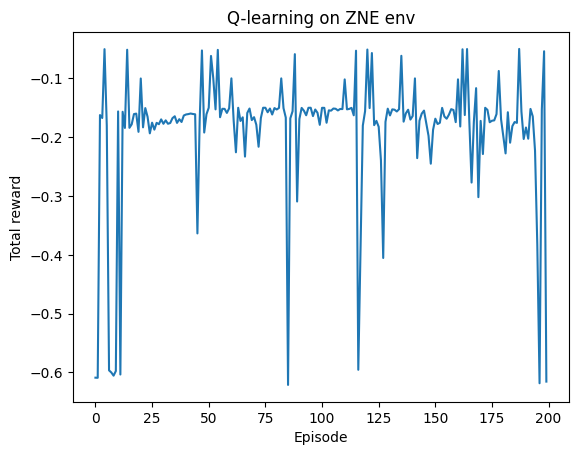

ideal=0.999212, est=0.318008, lambdas=[3.0, 3.0, 3.0], vals=[0.977107 0.938803 0.946164]
ideal=0.999212, est=0.316940, lambdas=[3.0, 3.0, 3.0], vals=[0.942029 0.9377   0.972733]
ideal=0.999212, est=0.317622, lambdas=[3.0, 3.0, 3.0], vals=[0.961214 0.938444 0.958941]
ideal=0.999212, est=0.313382, lambdas=[3.0, 3.0, 3.0], vals=[0.924117 0.933893 0.962432]
ideal=0.999212, est=0.313632, lambdas=[3.0, 3.0, 3.0], vals=[0.931492 0.934838 0.956355]


/usr/local/lib/python3.12/dist-packages/scipy/sparse/linalg/_dsolve/linsolve.py:606: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/usr/local/lib/python3.12/dist-packages/scipy/sparse/linalg/_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)
/usr/local/lib/python3.12/dist-packages/mitiq/zne/inference.py:169: ExtrapolationWarning: The extrapolation fit may be ill-conditioned. Likely, more data points are necessary to fit the parameters of the model.
  opt_params, params_cov = np.polyfit(
/usr/local/lib/python3.12/dist-packages/mitiq/zne/inference.py:173: ExtrapolationWarning: The extrapolation fit may be ill-conditioned. Likely, more data points are necessary to fit the parameters of the model.
  opt_params = np.polyfit(scale_factors, exp_values, deg, w=weights)
/usr/local/lib/python3.12/dist-packages/scipy/sparse/linalg/_dsolve/linsolve.py:606: SparseEfficiencyWar

In [19]:

# Training + evaluation
from tqdm import tqdm
import matplotlib.pyplot as plt

# initialize environment + agent
env0 = env_generator_hamiltonian(n_qubits=3, trotter_steps=2, dt=0.1, Jx=0.5, hz=0.7)
agent = QLearningAgent(state_dim=4, action_dim=env0.ACTIONS_PER_STEP, step_size=0.1, epsilon=0.2, gamma=0.95)

def train_rl_zne(agent, env_gen, episodes=200):
    rewards = []
    for ep in tqdm(range(episodes), desc="Training RL Agent"):
        env = env_gen()
        state = env.reset()
        total_reward = 0.0
        while True:
            action = agent.choose_action(state)
            next_state, reward, done, info = env.step(action)
            agent.update(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            if done:
                break
        rewards.append(total_reward)
    return rewards

# train for  number of episodes
rewards = train_rl_zne(agent, lambda: env_generator_hamiltonian(n_qubits=3, trotter_steps=2, dt=0.1, Jx=0.5, hz=0.7), episodes=200)

plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Total reward")
plt.title("Q-learning on ZNE env")
plt.show()

# evaluate few episodes
def evaluate_agent(agent, env_gen, episodes=5):
    stats = []
    for _ in range(episodes):
        env = env_gen()
        state = env.reset()
        # choose first extrapolator greedily
        a = np.argmax(agent.get_qs(state))
        state, _, _, _ = env.step(a)
        # then choose until stop
        while True:
            a = np.argmax(agent.get_qs(state))
            state, r, done, info = env.step(a)
            if done:
                stats.append(info)
                break
    return stats

stats = evaluate_agent(agent, lambda: env_generator_hamiltonian(n_qubits=3, trotter_steps=2, dt=0.1, Jx=0.5, hz=0.7), episodes=5)
for s in stats:
    print("ideal={:.6f}, est={:.6f}, lambdas={}, vals={}".format(s["ideal"], s["est"], s["lambdas"], np.round(s["vals"], 6)))
